Extra libraries needed to read synchronic map data files.

In [ ]:
!apt-get install build-essential python3-dev python3-numpy libhdf4-dev -y
!pip install pyhdf
!pip install sunpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
libhdf4-dev is already the newest version (4.2.13-2).
python3-dev is already the newest version (3.6.7-1~18.04).
The following packages were automatically installed and are no longer required:
  default-libmysqlclient-dev libarmadillo-dev libarpack2-dev libdap-dev
  libdapserver7v5 libepsilon-dev libfreexl-dev libfyba-dev libgeos-dev
  libgeotiff-dev libgif-dev libjson-c-dev libkml-dev libkmlconvenience1
  libkmlregionator1 libkmlxsd1 libminizip-dev libmysqlclient-dev libnetcdf-dev
  libogdi3.2-dev libopenjp2-7-dev libpoppler-dev libpoppler-private-dev
  libpq-dev libproj-dev libqhull-dev libqhull-r7 libspatialite-dev
  libsqlite3-dev libsuperlu-dev liburiparser-dev libwebp-dev libxerces-c-dev
  unixodbc-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly ins

[Not required if you don't want to save files !] Mount your Google Drive. Follow instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

[Not required if you don't want to save files !] Change to local directory inside your Google Drive.

In [ ]:
%cd "/content/drive/MyDrive/SEARCH_wnet/data"

Imports

In [ ]:
# Required for K-means
import numpy as np
from sklearn import cluster
# Not required for K-means (libraries for plotting, analysis, etc.)
import os
from pyhdf.SD import SD, SDC
import pickle
import sunpy.visualization.colormaps as cm
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.colors as colors
from matplotlib import cm as cmm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
plt.rcParams["font.family"] = "Times New Roman"

Libraries to download and read synchronic maps.

In [ ]:
# Read hdf file
def read_hdf(filename, hdf_key='Data-Set-2'):
  hdf = SD(filename, SDC.READ)
  hdf_data = hdf.select(hdf_key)
  hdf_img= hdf_data.get()

  return hdf_img

# Credit: Brent Smith
'''
##############################################################################
Synchronic Imagery Retrieval
##############################################################################
'''
# imports (std lib)
import sys
import logging
import argparse
# imports (3rd party)
import requests
# imports (local)

#=============================================================================
def get_files(map_type, first_map, last_map):
    '''
       #######################################################################
       Retrieval of imagery through web-scraping.
       #######################################################################
    '''
    base_url = 'http://predsci.com/chd/data/maps/hdf/' + map_type + '/'

    r = requests.get(base_url)
    lines = r.text.splitlines()
    links = [line for line in lines if 'href' in line and '.hdf' in line]
    links = links[first_map:last_map]
    for link in links:
        url = link.split('href')[-1].split('hdf')[0][2:] + 'hdf'
        name = url #link.split()
        print('downloading...' + name)
        with open(name, 'wb') as f:
            f.write(requests.get(base_url + url).content)
    return name


Functions for K-means (Elbow method, plotting clusters).

In [ ]:
# Plot masked predicted clusters
def plot_predicted_clusters(euv_data, kmeans_predict, num_clusters=5, line_thickness=1):

  # Figure
  frame = 0
  font_size = 10
  figsize_x = 8.0
  figsize_y = 4.0
  x_label = r'Heliographic Longitude $\phi$ [°]'
  y_label = r'Heliographic Latitude $\theta$ [°]'
  colorbar_cmap = plt.get_cmap('sohoeit195')
  colorbar_label = r'Log-normalized Intensity'
  plt.rcParams["font.family"] = "Times New Roman"
  x = np.linspace(0, 360.0, ny)-180.0
  y = np.linspace(0, 180.0, nx)-90.0
  where_badpix = np.where(euv_data == -9999)
  euv_data[where_badpix] = np.nan
  vmin = np.nanmin(10.**euv_data)
  vmax = np.nanmax(10.**euv_data)
  euv_data = 10.**euv_data

  # Loop over clusters
  for j in range(num_clusters):

    arr = np.where(kmeans_predict == j, 1., 0.)
    z = np.zeros((nx, ny))
    output = np.zeros((nx, ny))
    for i in range(1, line_thickness):
      xp = np.concatenate((z[:i, :], arr[0:nx-i, :]), axis=0)
      xm = np.concatenate((arr[i:, :], z[nx-i:, :]), axis=0)
      yp = np.concatenate((z[:, :i], arr[:, 0:ny-i]), axis=1)
      ym = np.concatenate((arr[:, i:], z[:, ny-i:]), axis=1)
      ii = np.where(arr + xp == 1)
      output[ii] = 1
      ii = np.where(arr + xm == 1)
      output[ii] = 1
      ii = np.where(arr + yp == 1)
      output[ii] = 1
      ii = np.where(arr + ym == 1)
      output[ii] = 1
    cluster_masked = np.ma.masked_where(output == 0, output)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x, figsize_y))
    I = ax.imshow(euv_data, extent=[min(x), max(x), min(y), max(y)], cmap=colorbar_cmap, interpolation='none', origin='lower', norm=colors.LogNorm(vmin=vmin, vmax=vmax))   
    I2 = ax.imshow(cluster_masked, extent=[min(x), max(x), min(y), max(y)], cmap='spring_r', interpolation='none', origin='lower', alpha=1.0) 
    ax.get_yaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, left=True, right=True)
    ax.set_ylabel(y_label, fontsize=font_size, labelpad=5.0)
    ax.get_xaxis().set_tick_params(which='both', direction='out', width=1, length=2.5, labelsize=font_size, bottom=True, top=True)
    ax.set_xlabel(x_label, fontsize=font_size, labelpad=3.0)
    ax.get_xaxis().set_major_locator(plt.MultipleLocator(60))
    ax.get_yaxis().set_major_locator(plt.MultipleLocator(30))
    # Title
    ax.set_title(r'K-means Cluster {0}/{1}: SDO/AIA 193Å + STEREO/EUVI 195Å on '.format(j+1, num_clusters), fontsize=font_size, y=1.02, wrap=True)
    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0)
    cb = colorbar(I, extend='neither', cax=cax)
    cb.ax.tick_params(axis='y', direction='out', labelsize=font_size, width=1, length=2.5)
    cb.set_label(colorbar_label, labelpad=20.0, rotation=270, size=font_size)
    # plt.savefig('Fig_Kmeans_cluster_{0}.png'.format(j), format='png', dpi=200)
    plt.draw()


# Credit: Matthew Penn (NVIDIA)
def compute_elbow(elbow_arr):
  curve = elbow_arr
  nPoints = len(curve)
  allCoord = np.vstack((range(nPoints), curve)).T
  np.array([range(nPoints), curve])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  rep1, rep2 = np.repeat(lineVecNorm[0], nPoints), np.repeat(lineVecNorm[1],nPoints)
  rep = np.empty((nPoints, 2))
  rep[:,0] = rep1
  rep[:,1] = rep2
  scalarProduct = np.sum(vecFromFirst * rep, axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  idxOfBestPoint = np.argmax(distToLine)
  return idxOfBestPoint

# Elbow method function
def elbow_method(img):
  epsilon = []
  k_min = 2
  k_max = 20
  K = range(k_min, k_max)

  # Reshape euv image for Kmeans
  img_reshape = img.reshape(img.shape[0] * img.shape[1], 1)

  # For each number of clusters, run kmeans and store inertia value as epsilon
  for k in K:
    kmeans = cluster.KMeans(n_clusters=k, random_state=0).fit(img_reshape)
    epsilon.append(kmeans.inertia_) 

  # Function to compute correct # of clusters from epsilon array here
  num_clusters = compute_elbow(epsilon) + k_min

  return num_clusters

Synchromic map parameters:

In [ ]:
# EUV and CHM data
euv_key = 'Data-Set-2'
chm_key = 'Data-Set-2'
# Sine-latitude (sine(radians))
lat_key = 'fakeDim0'
# Longitude (radians)
long_key = 'fakeDim1'
# Image dimensions
nx = 1600
ny = 3200

Training and test sets (10 images for the training set, 1 image for the test set in this example):

In [ ]:
# Define arrays
size_train = 10
size_test = 1
size_total = size_train + size_test
train_set = np.zeros((size_train, nx, ny))
test_set = np.zeros((size_test, nx, ny))

# Shuffle list of file numbers (e.g, file #0, file #1, etc.)
file_nb_min = 2000
file_nb_max = 6003
file_nb = np.random.randint(file_nb_min, high=file_nb_max, size=size_total, dtype='l')
file_train = file_nb[0:size_train]
file_test = file_nb[size_train:size_train+size_test]

# Read EUV files
file_type = 'euv'
for i in range(size_train):
  filename = get_files(file_type, file_train[i], file_train[i]+1)
  train_set[i, :, :] = read_hdf(filename).astype(float)

for i in range(size_test):
  filename = get_files(file_type, file_test[i], file_test[i]+1)
  test_set[i, :, :] = read_hdf(filename).astype(float)

downloading...maps_r101_euv_2802.hdf
downloading...maps_r101_euv_5424.hdf
downloading...maps_r101_euv_5094.hdf
downloading...maps_r101_euv_2276.hdf
downloading...maps_r101_euv_4420.hdf
downloading...maps_r101_euv_2959.hdf
downloading...maps_r101_euv_4457.hdf
downloading...maps_r101_euv_3674.hdf
downloading...maps_r101_euv_5528.hdf
downloading...maps_r101_euv_3063.hdf
downloading...maps_r101_euv_2252.hdf


Training:

In [ ]:
# Reshape euv images to (pixel area * nb_files, 1)
train_set = train_set.reshape(size_train * nx * ny, 1)

# Apply the elbow method
# num_clusters = elbow_method(train_set)
# print('Number of clusters suggested by the Elbow method: {0}'.format(num_clusters))

# Run Kmeans on the euv_img_reshape array
num_clusters = 6
kmeans = cluster.KMeans(n_clusters = num_clusters, random_state=0).fit(train_set)

# Save trained Kmeans using pickle
# pickle.dump(kmeans, open("save.pkl", "wb"))

Test set:

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


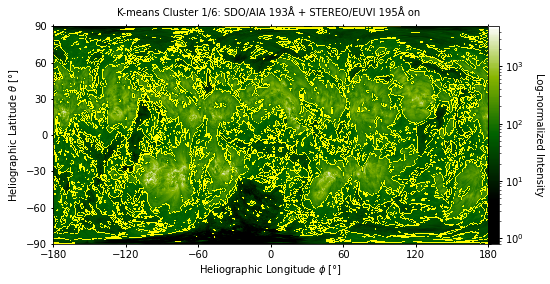

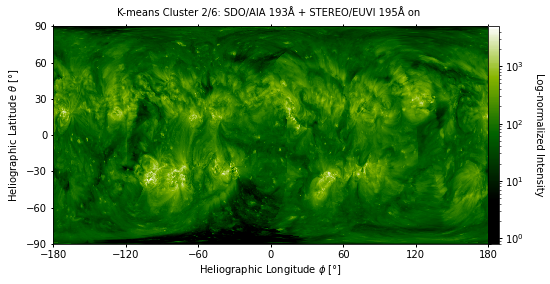

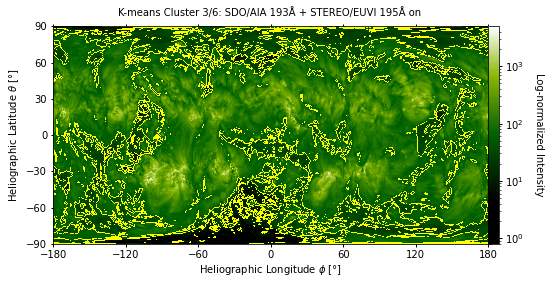

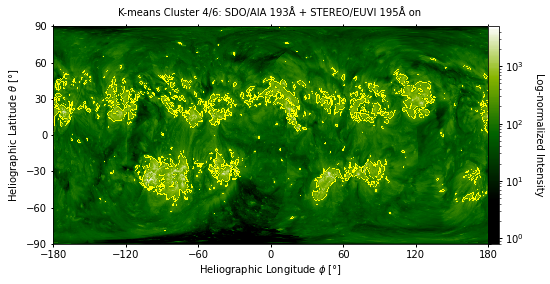

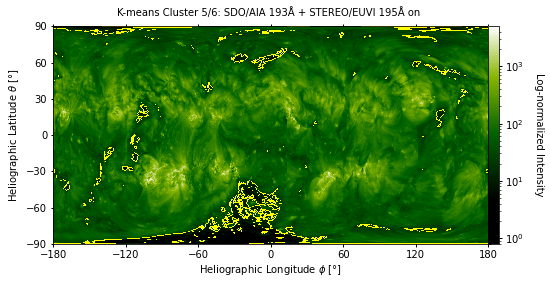

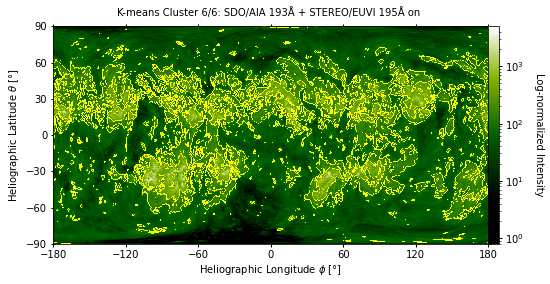

In [ ]:
# Retrieve Kmeans from pickle
# kmeans = pickle.load(open("save.pkl", "rb"))

# Plot images and print percentage of coronal holes in each image band
for i in range(size_test):
  kmeans_predict = kmeans.predict(test_set[i, :, :].reshape(nx * ny, 1))
  kmeans_predict = kmeans_predict.reshape(nx, ny)

  # Plot clusters
  plot_predicted_clusters(test_set[i, :, :], kmeans_predict, num_clusters = num_clusters, line_thickness=4)

**Alternative training approach:** We manually remove bad pixels (-9999 values) beforehand.

In [ ]:
# Reshape euv images to (pixel area * nb_files, 1)
train_set = train_set.reshape(size_train * nx * ny, 1)
# Extract only the good pixels
goodpixels = np.where(train_set > -9999)
nb_goodpixels = len(goodpixels[0])
train_set = train_set[goodpixels].reshape(nb_goodpixels, 1)

# Apply the elbow method
# num_clusters = elbow_method(train_set)
# print('Number of clusters suggested by the Elbow method: {0}'.format(num_clusters))

# Run Kmeans on the euv_img_reshape array
num_clusters = 5
kmeans = cluster.KMeans(n_clusters = num_clusters, random_state=0).fit(train_set)

# Save trained Kmeans using pickle
# pickle.dump(kmeans, open("save.pkl", "wb"))

Test set:

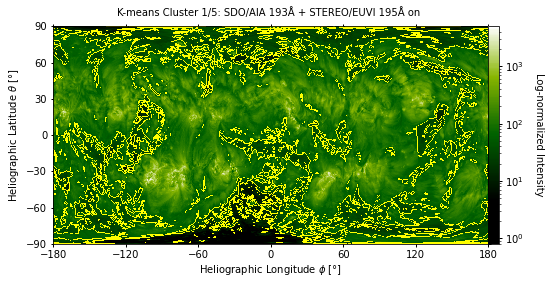

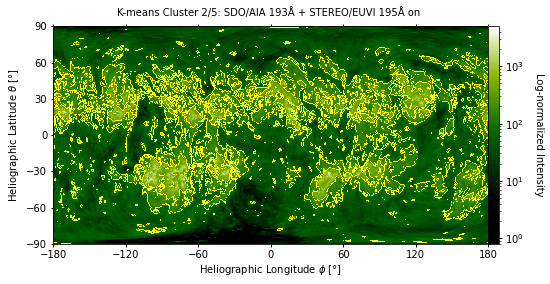

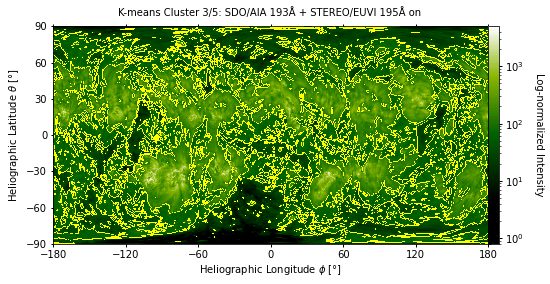

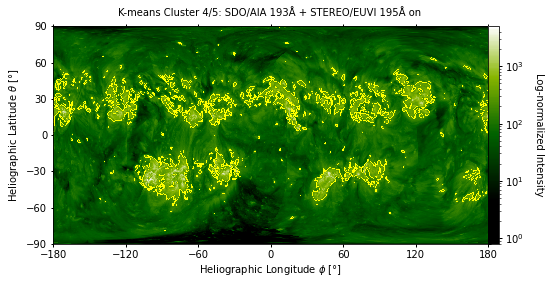

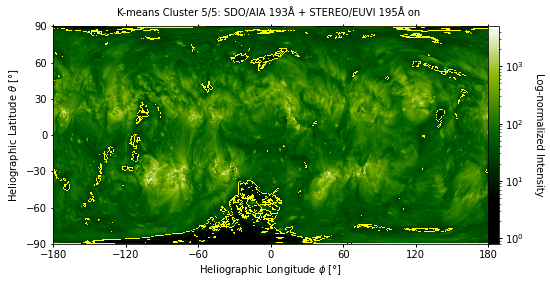

In [ ]:
# Retrieve Kmeans from pickle
# kmeans = pickle.load(open("save.pkl", "rb"))

# Plot images and print percentage of coronal holes in each image band
for i in range(size_test):
  kmeans_predict = kmeans.predict(test_set[i, :, :].reshape(nx * ny, 1))
  kmeans_predict = kmeans_predict.reshape(nx, ny)

  # Plot clusters
  plot_predicted_clusters(test_set[i, :, :], kmeans_predict, num_clusters = num_clusters, line_thickness=4)